#### Import and set up paths

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from skimage.io import imread
from pathlib import Path
import pandas as pd
import cv2
import random
import logging

import torch
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
import torchvision 
from torchvision import datasets, transforms, utils
from torchsummary import summary
import torch.optim as optim

!pip install xmltodict
import xmltodict

from google.colab import drive
drive.mount('/content/drive')

In [17]:
root_directory = Path("/content/")
drive_path = root_directory / 'drive/MyDrive' / 'CS101' 

#### Data preparation

In [ ]:
# Path to zip file in my drive
!unzip '/content/drive/My Drive/CS101/CS101_z.zip'

In [18]:
class EmbryoDataset(Dataset):

    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        image_list_file = os.path.join(self.data_dir, 'fluo.list') 
        gt_list_file = os.path.join(self.data_dir, 'xml.list')

        with open(image_list_file, 'r') as f:
            self.image_list = f.read().splitlines()
        with open(gt_list_file, 'r') as f:
            self.gt_list = f.read().splitlines()

        self.data_dir = data_dir
        self.length = len(self.image_list)
        self.transform = transform

    def __getitem__(self, index):
        image_path = os.path.join(self.data_dir, self.image_list[index])
        gt_path = os.path.join(self.data_dir, self.gt_list[index])

        image = cv2.imread(image_path)
        with open(gt_path, 'r') as f:
            dic = xmltodict.parse(f.read())
        box_dic = dic['annotation']['object']
        if not isinstance(box_dic, list):
            box = list(map(int, box_dic['bndbox'].values()))
            boxes = [box]
        else:
            boxes = []
            for i in range(len(box_dic)):
                box = list(map(int, box_dic[i]['bndbox'].values()))
                boxes.append(box)    
        image = self.image_transform(image)
        boxes = torch.FloatTensor(boxes)
        label = [1] * len(boxes)
        label = torch.LongTensor(label)

        return image, boxes, label

    def __len__(self):
        return self.length

    def image_transform(self, image):
        trans = transforms.Compose([transforms.ToTensor()])
        return trans(image)

In [19]:
# Instantiate train, validation, and test dataloaders
train_set = EmbryoDataset(root_directory / 'CS101_z' / 'trainset')
test_set = EmbryoDataset(root_directory / 'CS101_z' / 'testset')
val_set = EmbryoDataset(root_directory / 'CS101_z' / 'valset')

batch_size = 8

def collate_fn(batch):
    return list(zip(*batch))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn = collate_fn)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, collate_fn = collate_fn)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, collate_fn = collate_fn)

dataloaders = {"train": train_loader, "test": test_loader, "val": val_loader}

tensor([[169., 350., 245., 399.]])
tensor([1])


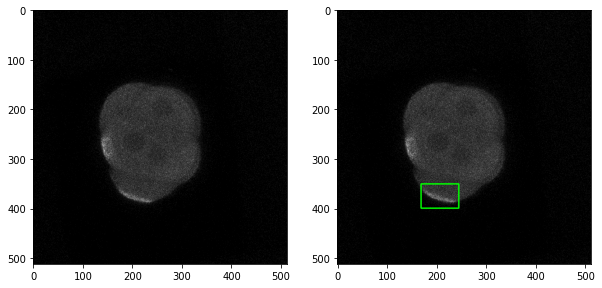

In [20]:
# visualize the data
images, boxes, labels = next(iter(train_loader))
image = images[0]
box = boxes[0]
label = labels[0]
image = image.numpy().transpose((1,2,0))
def imshow(image, box, label):
    fig = plt.figure(figsize = (10, 10))
    ax1 = fig.add_subplot(121)
    plt.imshow(image[:,:,0], cmap='gray')
    gt = image
    for i in range(box.shape[0]):
        bbox = box[i, :]
        gt = cv2.rectangle(gt, tuple(bbox[:2]), tuple(bbox[2:]), (0, 1, 0), 2)
    ax2 = fig.add_subplot(122)
    plt.imshow(cv2.UMat.get(gt))
    print(box)
    print(label)
imshow(image, box, label)


#### Declare training loop

In [21]:
from collections import defaultdict
import torch.nn.functional as F

def train_model(model, optimizer, scheduler, checkpoint_path, num_epochs=25):
    best_loss = 1e10
    metrics = defaultdict(float)
    metrics['loss'] = 0
    samples = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        epoch_loss_full = defaultdict(float)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode

            epoch_metrics = defaultdict(float)
            epoch_metrics['loss'] = 0
            epoch_samples = 0

            for images, boxes, labels in tqdm(dataloaders[phase]):
                image_list = []
                target_list = []
                for i in range(len(images)):
                    image_list.append(images[i].to(device))
                    target_list.append({'boxes':boxes[i].to(device),'labels':labels[i].to(device)})

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    losses = model(image_list, target_list)
                    loss = sum(loss_item for loss_item in losses.values())
                    if phase == 'train':
                        metrics['loss'] += loss.item()
                    else:
                        epoch_metrics['loss'] += loss.item()

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                if phase == 'val':
                    epoch_samples += len(images)
                elif phase == 'train':
                    samples += len(images)
                    print(metrics['loss'] / samples)
                    iteration = samples // len(images)

                    # save checkpoint every 500 steps
                    if iteration % 500 == 1:
                        torch.save(model.state_dict(), os.path.join(checkpoint_path, '{}.pth'.format(iteration)))

            if phase == 'train':
                # Update the learning rate
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
            
            if phase == 'val':
                print('val_loss: {}', epoch_metrics['loss'] / epoch_samples)

            if phase == 'val' and (epoch_metrics['loss'] / epoch_samples) < best_loss:
                # save the model weights
                best_loss = epoch_metrics['loss'] / epoch_samples
                torch.save(model.state_dict(), os.path.join(checkpoint_path, 'best.pth'))

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best val loss: {:4f}'.format(best_loss))

#### Declare Model

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device', device)

#model = torchvision.models.detection.ssd300_vgg16(pretrained_backbone=True, num_classes=2)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(num_classes=2, pretrained_backbone=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)
model.roi_heads.nms_thresh = 0.1
model = model.to(device)

#### Train model

In [ ]:
# when training, change to your own log and checkpoint path
log_path = drive_path / 'exps' / 'jiajun' / 'exp16' / 'logs'
checkpoint_path = drive_path / 'exps' / 'jiajun' / 'exp16' / 'checkpoints'
writer = SummaryWriter(log_path)

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=8, gamma=0.1)
train_model(model, optimizer_ft, exp_lr_scheduler, checkpoint_path, num_epochs=20)

#### Evaluate performance and visualize

In [ ]:
# load checkpoint
checkpoint_path = drive_path / 'exps' / 'jiajun' / 'exp16' / 'checkpoints'
model_path = checkpoint_path / 'fluo.pth'
model.load_state_dict(torch.load(model_path))
model.eval()

  0%|          | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 12/12 [00:07<00:00,  1.66it/s]

[[0.84831461 0.84831461 0.84831461 0.84550562 0.84269663 0.84269663
  0.83988764 0.83426966 0.8258427 ]]
[[0.8856305  0.89614243 0.90419162 0.90936556 0.9202454  0.92592593
  0.92857143 0.93690852 0.9483871 ]]


Text(0.5, 1.0, 'PR curve')

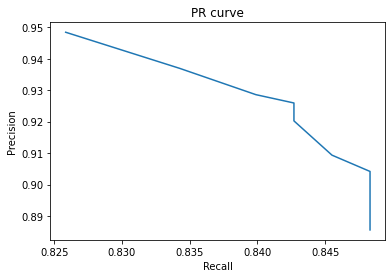

In [26]:
# calculate recall/precision and draw pr curve
def cal_metrics(res_dic, box_gt):
    iou_thresh = 0.3
    score_threshs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    TP = np.zeros((1, 9))
    FP = np.zeros((1, 9))
    FN = np.zeros((1, 9))
    for index, score_thresh in enumerate(score_threshs):
        for i in range(res_dic['boxes'].shape[0]):
            if res_dic['scores'][i] < score_thresh:
                break
        box_pred = res_dic['boxes'][:i,:]
        iou_matrix = torchvision.ops.box_iou(box_pred, box_gt)
        used = np.zeros((1, box_gt.shape[0]))
        for i in range(iou_matrix.shape[0]):
            max_index = torch.argmax(iou_matrix, dim=1)[i]
            if iou_matrix[i, max_index] >= iou_thresh:
                used[0, max_index] = 1
                for j in range(iou_matrix.shape[0]):
                    iou_matrix[j, max_index] = 0.0
                TP[0, index] += 1
            else:
                FP[0, index] += 1
        for i in range(box_gt.shape[0]):
            if used[0, i] == 0:
                FN[0, index] += 1

    return TP, FP, FN

TP = np.zeros((1, 9))
FP = np.zeros((1, 9))
FN = np.zeros((1, 9))
for images, boxes, labels in tqdm(dataloaders['test']):
    image_list = list(image.to(device) for image in images)
    tmp_res = model(image_list)
    for i in range(len(tmp_res)):
        tmp_tp, tmp_fp, tmp_fn = cal_metrics(tmp_res[i], boxes[i].to(device))
        TP += tmp_tp
        FP += tmp_fp
        FN += tmp_fn

recall = TP / (TP + FN)
precision = TP / (TP + FP)
print(recall)
print(precision)
plt.plot(recall[0,:], precision[0,:])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR curve')

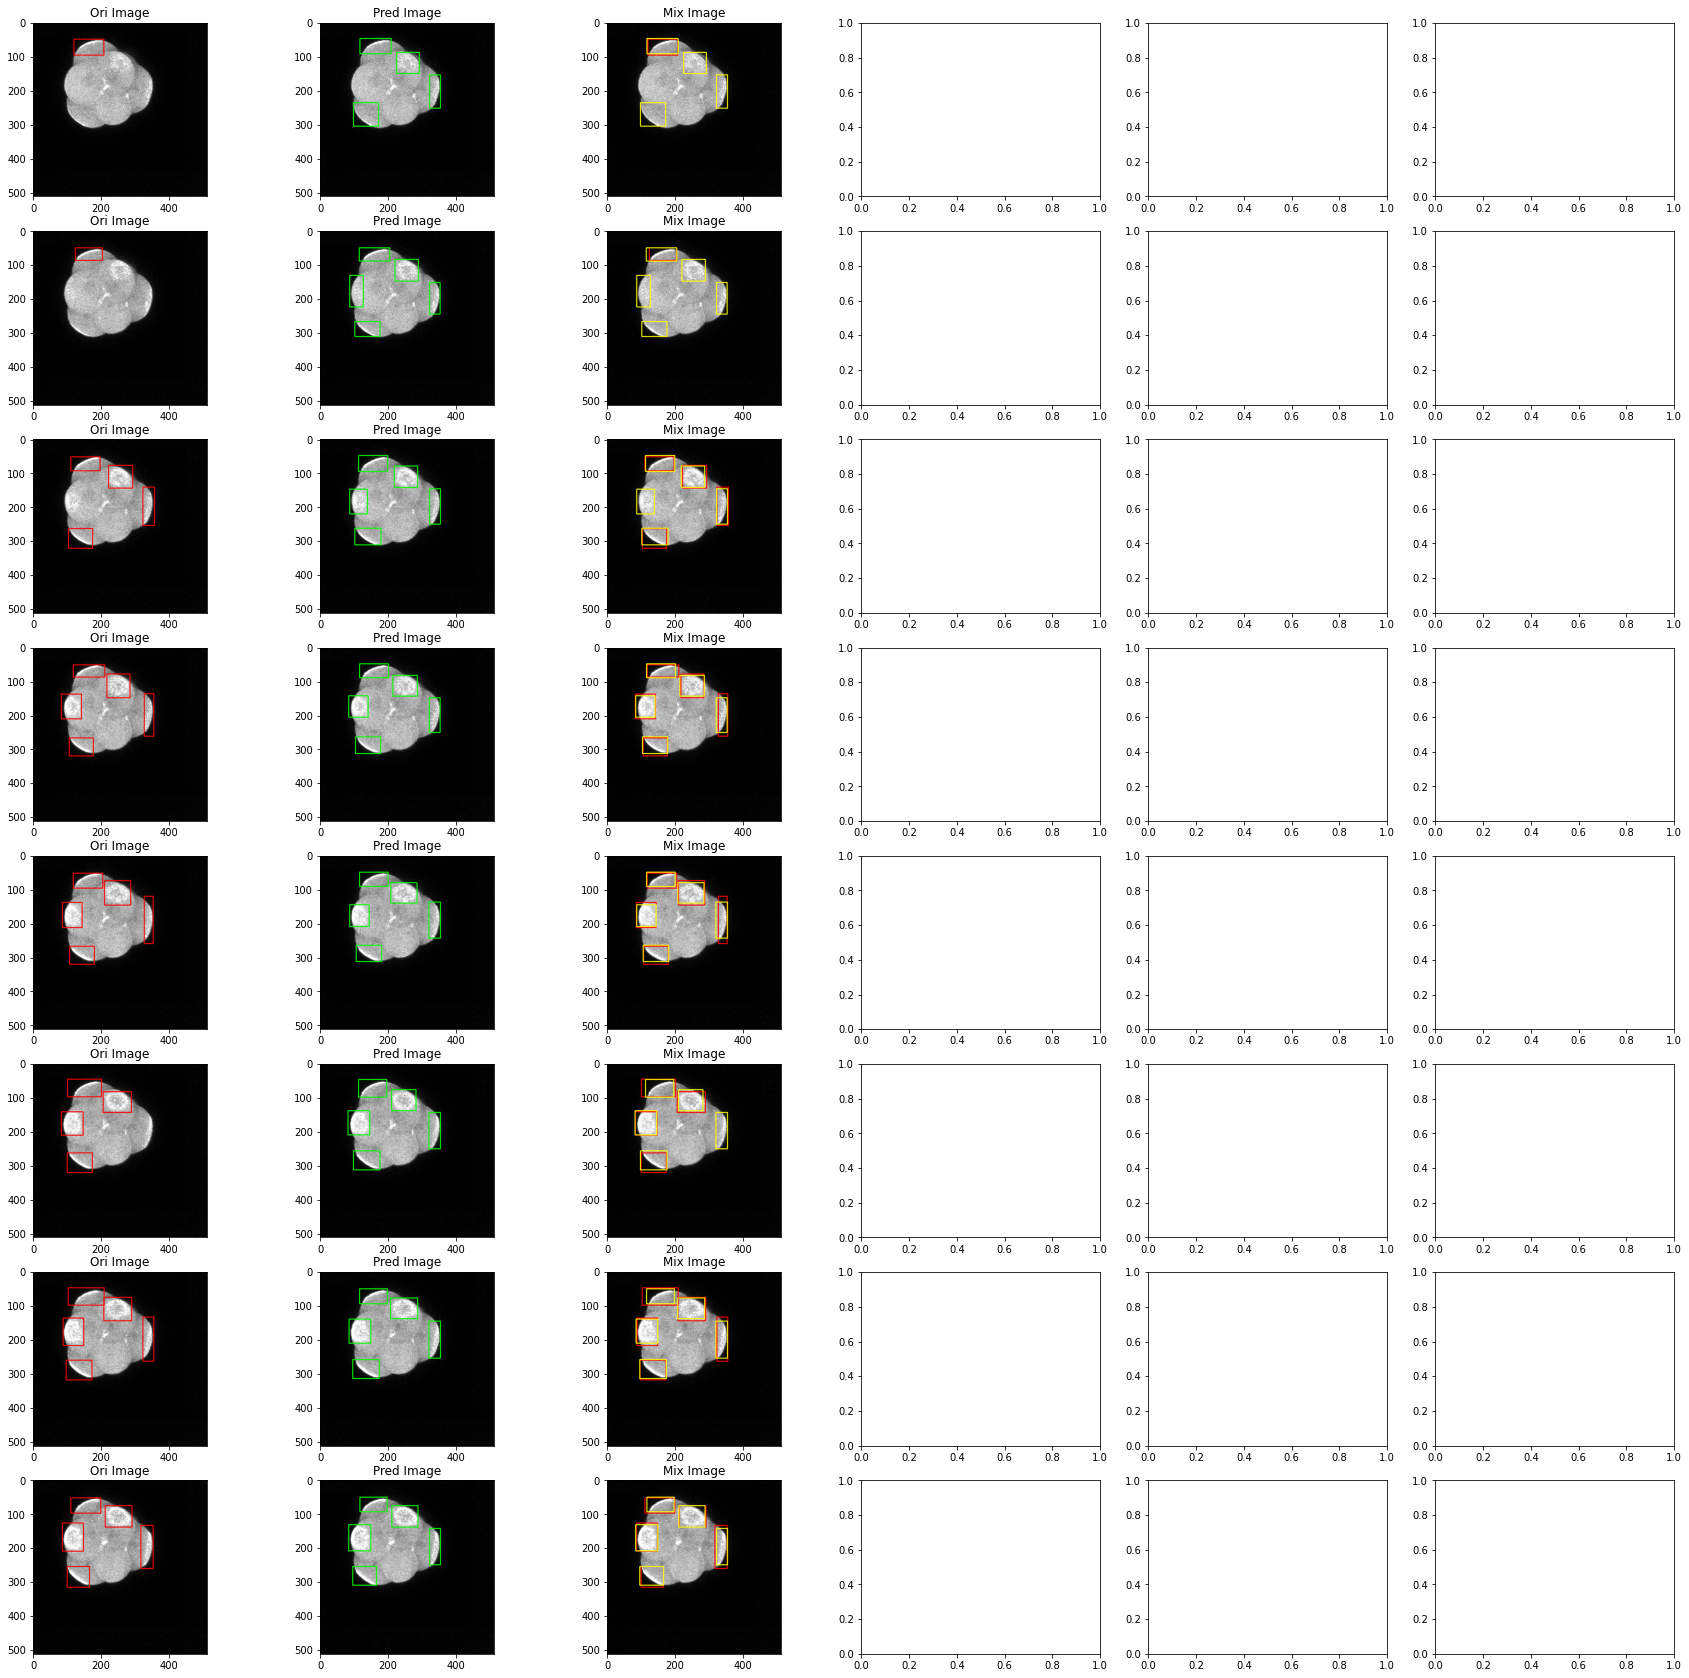

In [28]:
from google.colab.patches import cv2_imshow

# visualize the results
images, boxes, labels = next(iter(test_loader))
image_list = []
for i in range(len(images)):
    image_list.append(images[i].to(device))
res = model(image_list)

def imshow(images, boxes, res):
  fig, axs = plt.subplots(8, 6, figsize=(30, 30))
  for index in range(8):
      image = images[index].numpy().transpose((1,2,0))
      box = boxes[index].numpy()
      ori_image = image
      pred_image = image
      mix_image = image
      for i in range(box.shape[0]):
            ori_image = cv2.rectangle(ori_image, tuple(box[i,:2]), tuple(box[i, 2:]), (1, 0, 0), 2)
            mix_image = cv2.rectangle(mix_image, tuple(box[i,:2]), tuple(box[i, 2:]), (1, 0, 0), 2)
      for i in range(res[index]['boxes'].shape[0]):
          pred_box = res[index]['boxes'][i,:].cpu().detach().numpy()
          if res[index]['scores'][i] > 0.2:
              pred_image = cv2.rectangle(pred_image, tuple(pred_box[:2]), tuple(pred_box[2:]), (0, 1, 0), 2)
              mix_image = cv2.rectangle(mix_image, tuple(pred_box[:2]), tuple(pred_box[2:]), (1, 1, 0), 2)
      axs[index,0].set_title("Ori Image")
      axs[index,0].imshow(cv2.UMat.get(ori_image))

      axs[index,1].set_title("Pred Image")
      axs[index,1].imshow(cv2.UMat.get(pred_image))

      axs[index,2].set_title("Mix Image")
      axs[index,2].imshow(cv2.UMat.get(mix_image))

imshow(images, boxes, res)